In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
normal_dir = "/Users/dikshanta/Downloads/TB_Chest_Radiography_Database/Normal"
tb_dir = "/Users/dikshanta/Downloads/TB_Chest_Radiography_Database/Tuberculosis"


In [4]:
class TuberDataset(Dataset):
    def __init__(self, normal_dir, tb_dir, transform=None):
        self.data = []
        self.transform = transform

        for img_name in os.listdir(normal_dir):
            img_path = os.path.join(normal_dir, img_name)
            self.data.append((img_path, 0))  # 0 = Normal

        for img_name in os.listdir(tb_dir):
            img_path = os.path.join(tb_dir, img_name)
            self.data.append((img_path, 1))  # 1 = TB

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = TuberDataset(normal_dir, tb_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
# 🧠 Model Definition: Basic Convolutional Neural Network for Binary Classification (TB vs Normal)

class TuberCNN(nn.Module):
    def __init__(self):
        super(TuberCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (224 -> 112)
        x = self.pool(F.relu(self.conv2(x)))  # (112 -> 56)
        x = x.view(-1, 32 * 56 * 56)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = TuberCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


TuberCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [7]:
# ⚙️ Training Setup: Loss Function and Optimizer for Binary Classification

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# 🔁 Training Loop: Train for a Few Epochs and Track Loss

num_epochs = 5  # You can increase this later

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 105/105 [00:38<00:00,  2.72it/s]


Epoch [1/5], Loss: 0.2230


100%|██████████| 105/105 [00:38<00:00,  2.72it/s]


Epoch [2/5], Loss: 0.0858


100%|██████████| 105/105 [00:39<00:00,  2.64it/s]


Epoch [3/5], Loss: 0.0488


100%|██████████| 105/105 [00:39<00:00,  2.68it/s]


Epoch [4/5], Loss: 0.0402


100%|██████████| 105/105 [00:39<00:00,  2.69it/s]

Epoch [5/5], Loss: 0.0234


Test Accuracy: 0.9917


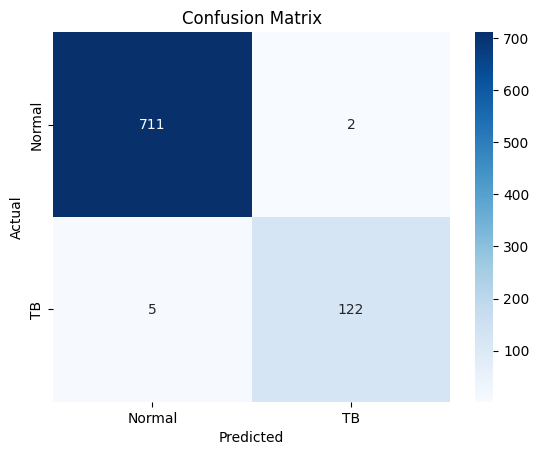

In [11]:
# 📈 Model Evaluation: Accuracy and Confusion Matrix on Test Set

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "TB"], yticklabels=["Normal", "TB"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


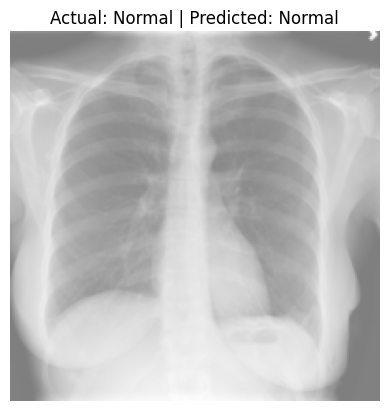

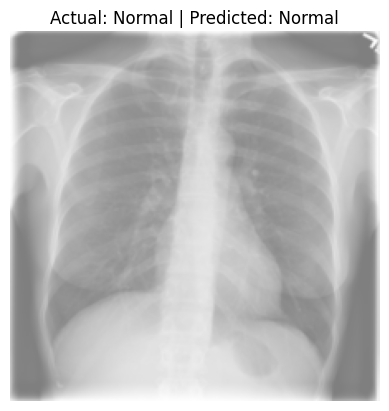

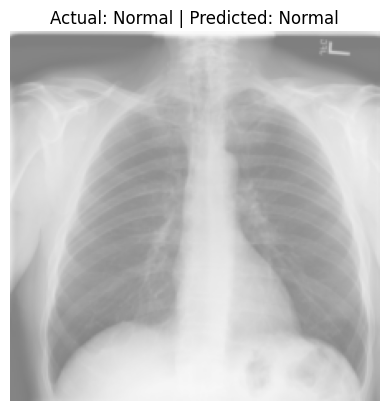

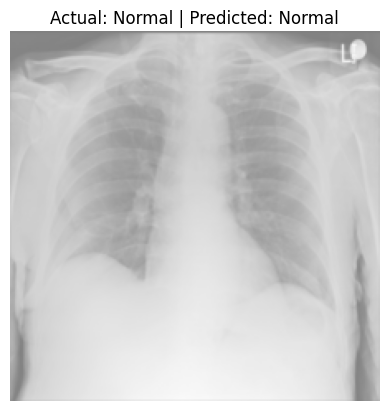

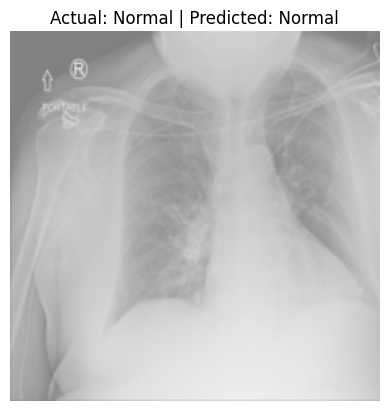

In [13]:
# 🖼️ Visual Check: Display Sample Images with Predicted Labels

def imshow(img_tensor, actual_label, predicted_label):
    img = img_tensor / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Display 5 images
for i in range(5):
    imshow(
        images[i].cpu(),
        actual_label="TB" if labels[i] == 1 else "Normal",
        predicted_label="TB" if preds[i] == 1 else "Normal"
    )


In [14]:
# 💾 Save the trained model
MODEL_PATH = "tuber_model.pth"
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")


Model saved to tuber_model.pth
